In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler
import numpy as np
import time
import matplotlib.pyplot as plt


In [2]:
pollution_data = pd.read_csv("datasets/pollution_data.csv")
pollution_data["pollution"]

0        129.0
1        148.0
2        159.0
3        181.0
4        138.0
         ...  
43795      8.0
43796     10.0
43797     10.0
43798      8.0
43799     12.0
Name: pollution, Length: 43800, dtype: float64

In [3]:
import numpy as np

def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:(i + window_size)])
        labels.append(data[i + window_size])
    return np.array(sequences), np.array(labels)

# Example data
data = np.array(pollution_data["pollution"])  # your_data_column should be a list or array of data
window_size = 100  # Example window size

# Create sequences and labels
sequences, labels = create_sequences(data, window_size)


In [4]:
labels

array([27., 28., 21., ..., 10.,  8., 12.])

In [5]:
scaler = StandardScaler()
data_normalized = scaler.fit_transform(data.reshape(-1, 1)).flatten()  # Reshape for scaler and then flatten back
sequences_normalized, labels_normalized = create_sequences(data_normalized, window_size)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers) -> None:
        super(RNN, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # x -> batch_size, seq, input_size
        self.fc = nn.Linear(hidden_size, 1) #may need to change these params


    def forward(self, x, future_num=0):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])  # process the last output

        # Future predictions if needed
        outputs = [out]
        for _ in range(future_num):
            out, hn = self.rnn(out.unsqueeze(1), hn)  # Feed the last output back into the RNN
            out = self.fc(out[:, -1, :])
            outputs.append(out)

        return torch.stack(outputs, dim=1) if future_num > 0 else outputs[0]
         
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers) -> None:
        super(GRU, self).__init__()
        self.input_size=input_size
        self.hidden_size=hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # x -> batch_size, seq, input_size
        self.fc = nn.Linear(hidden_size, 1) #may need to change these params


    def forward(self, x, future_num=0):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # process the last output

        # Future predictions if needed
        outputs = [out]
        for _ in range(future_num):
            out, hn = self.gru(out.unsqueeze(1), hn)  # Feed the last output back into the RNN
            out = self.fc(out[:, -1, :])
            outputs.append(out)

        return torch.stack(outputs, dim=1) if future_num > 0 else outputs[0]


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Output one value per sequence

    def forward(self, x, future_num=0):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Last time step

        # Future predictions
        outputs = [out]
        for _ in range(future_num):
            out, (hn, cn) = self.lstm(out.unsqueeze(1), (hn, cn))
            out = self.fc(out[:, -1, :])
            outputs.append(out)

        return torch.stack(outputs, dim=1) if future_num > 0 else outputs[0]


In [8]:
total_samples = sequences_normalized.shape[0]
split_index = int(total_samples * 0.8)  # 80% for training, 20% for testing

# Split the data
X_train = torch.tensor(sequences_normalized[:split_index, :, np.newaxis], dtype=torch.float32)
y_train = torch.tensor(labels_normalized[:split_index], dtype=torch.float32)
X_test = torch.tensor(sequences_normalized[split_index:, :, np.newaxis], dtype=torch.float32)
y_test = torch.tensor(labels_normalized[split_index:], dtype=torch.float32)


In [9]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


In [10]:
batch_size = 32  # You can adjust the batch size depending on your memory capacity and model needs

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [11]:
input_size = 1
hidden_size = 20
num_layers = 2

In [12]:
rnn_model = RNN(input_size, hidden_size, num_layers).to(device)
gru_model = GRU(input_size, hidden_size, num_layers).to(device)
lstm_model = LSTM(input_size, hidden_size, num_layers).to(device)

In [13]:
import torch

def calc_rmse(predictions, targets):
    return torch.sqrt(((predictions - targets) ** 2).mean())

def calc_mae(predictions, targets):
    return torch.abs(predictions - targets).mean()

def calc_mape(predictions, targets):
    return torch.mean(torch.abs((targets - predictions) / targets)) * 100


In [14]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    """Train the model."""
    train_history = {'loss': [], 'rmse': [], 'mae': [], 'mape': []}
    start_time = time.time()
    model.train()
    for epoch in range(num_epochs):
        total_loss, total_rmse, total_mae, total_mape = 0, 0, 0, 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension

            loss = criterion(outputs, targets)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # rmse = calc_rmse(outputs, targets).item()
            # mae = calc_mae(outputs, targets).item()
            # mape = calc_mape(outputs, targets).item()
            # train_history['loss'].append(loss)
            # train_history['rmse'].append(rmse)
            # train_history['mae'].append(mae)
            # train_history['mape'].append(mape)
            total_loss += loss.item()
            total_rmse += calc_rmse(outputs, targets).item()
            total_mae += calc_mae(outputs, targets).item()
            total_mape += calc_mape(outputs, targets).item()
        
        # Store metrics for training
        num_batches = len(train_loader)
        train_history['loss'].append(total_loss / num_batches)
        train_history['rmse'].append(total_rmse / num_batches)
        train_history['mae'].append(total_mae / num_batches)
        train_history['mape'].append(total_mape / num_batches)

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Total Training time: {training_time:.2f} seconds")
    return train_history

def evaluate_model(model, data_loader, device):

    model.eval()
    criterion_mse = torch.nn.MSELoss(reduction='sum')
    total_mse = 0.0
    total_mae = 0.0
    total_absolute_percentage_error = 0.0
    total_samples = 0
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            outputs = outputs.squeeze()  # Remove the extra dimension

            mse = criterion_mse(outputs, targets)
            mae = torch.nn.functional.l1_loss(outputs, targets, reduction='sum')
            
            percentage_error = torch.abs((outputs - targets) / targets)
            total_absolute_percentage_error += percentage_error.sum().item()
            
            total_mse += mse.item()
            total_mae += mae.item()
            total_samples += targets.size(0)

    rmse = np.sqrt(total_mse / total_samples)
    mae = total_mae / total_samples
    mape = (total_absolute_percentage_error / total_samples) * 100
    
    print(f'RMSE: {rmse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%')
    end_time = time.time()
    evaluation_time = end_time - start_time
    print(f"Total Evaluation time: {evaluation_time:.2f} seconds")
    return rmse, mae, mape

In [15]:

criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 30
rnn_training_data = train_model(rnn_model, train_loader, criterion, optimizer, num_epochs, device)
rnn_evaluation = evaluate_model(rnn_model, test_loader, device)

Epoch [1/30], Loss: 0.2529
Epoch [2/30], Loss: 0.1843
Epoch [3/30], Loss: 0.1797
Epoch [4/30], Loss: 0.1752
Epoch [5/30], Loss: 0.1730
Epoch [6/30], Loss: 0.1722
Epoch [7/30], Loss: 0.1713
Epoch [8/30], Loss: 0.1708
Epoch [9/30], Loss: 0.1705
Epoch [10/30], Loss: 0.1700
Epoch [11/30], Loss: 0.1695
Epoch [12/30], Loss: 0.1685
Epoch [13/30], Loss: 0.1682
Epoch [14/30], Loss: 0.1678
Epoch [15/30], Loss: 0.1676
Epoch [16/30], Loss: 0.1674
Epoch [17/30], Loss: 0.1670
Epoch [18/30], Loss: 0.1674
Epoch [19/30], Loss: 0.1667
Epoch [20/30], Loss: 0.1659
Epoch [21/30], Loss: 0.1659
Epoch [22/30], Loss: 0.1652
Epoch [23/30], Loss: 0.1650
Epoch [24/30], Loss: 0.1647
Epoch [25/30], Loss: 0.1654
Epoch [26/30], Loss: 0.1638
Epoch [27/30], Loss: 0.1641
Epoch [28/30], Loss: 0.1635
Epoch [29/30], Loss: 0.1633
Epoch [30/30], Loss: 0.1632
Total Training time: 81.04 seconds
RMSE: 0.2539, MAE: 0.1361, MAPE: 389.76%
Total Evaluation time: 0.24 seconds


In [16]:
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 30
gru_training_data = train_model(gru_model, train_loader, criterion, optimizer, num_epochs, device)
gru_evaluation = evaluate_model(gru_model, test_loader, device)




Epoch [1/30], Loss: 0.2908
Epoch [2/30], Loss: 0.1783
Epoch [3/30], Loss: 0.1725
Epoch [4/30], Loss: 0.1698
Epoch [5/30], Loss: 0.1687
Epoch [6/30], Loss: 0.1668
Epoch [7/30], Loss: 0.1658
Epoch [8/30], Loss: 0.1654
Epoch [9/30], Loss: 0.1646
Epoch [10/30], Loss: 0.1636
Epoch [11/30], Loss: 0.1631
Epoch [12/30], Loss: 0.1634
Epoch [13/30], Loss: 0.1619
Epoch [14/30], Loss: 0.1611
Epoch [15/30], Loss: 0.1611
Epoch [16/30], Loss: 0.1594
Epoch [17/30], Loss: 0.1604
Epoch [18/30], Loss: 0.1601
Epoch [19/30], Loss: 0.1591
Epoch [20/30], Loss: 0.1585
Epoch [21/30], Loss: 0.1584
Epoch [22/30], Loss: 0.1582
Epoch [23/30], Loss: 0.1576
Epoch [24/30], Loss: 0.1576
Epoch [25/30], Loss: 0.1578
Epoch [26/30], Loss: 0.1564
Epoch [27/30], Loss: 0.1560
Epoch [28/30], Loss: 0.1555
Epoch [29/30], Loss: 0.1546
Epoch [30/30], Loss: 0.1555
Total Training time: 82.95 seconds
RMSE: 0.2554, MAE: 0.1315, MAPE: 427.24%
Total Evaluation time: 0.24 seconds


In [17]:
criterion = nn.MSELoss()
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 30
lstm_training_data = train_model(gru_model, train_loader, criterion, optimizer, num_epochs, device)
lstm_evaluation = evaluate_model(gru_model, test_loader, device)

Epoch [1/30], Loss: 0.1549
Epoch [2/30], Loss: 0.1539
Epoch [3/30], Loss: 0.1534
Epoch [4/30], Loss: 0.1537
Epoch [5/30], Loss: 0.1533
Epoch [6/30], Loss: 0.1528
Epoch [7/30], Loss: 0.1526
Epoch [8/30], Loss: 0.1522
Epoch [9/30], Loss: 0.1513
Epoch [10/30], Loss: 0.1510
Epoch [11/30], Loss: 0.1503
Epoch [12/30], Loss: 0.1503
Epoch [13/30], Loss: 0.1492
Epoch [14/30], Loss: 0.1483
Epoch [15/30], Loss: 0.1480
Epoch [16/30], Loss: 0.1471
Epoch [17/30], Loss: 0.1465
Epoch [18/30], Loss: 0.1456
Epoch [19/30], Loss: 0.1456
Epoch [20/30], Loss: 0.1454
Epoch [21/30], Loss: 0.1440
Epoch [22/30], Loss: 0.1445
Epoch [23/30], Loss: 0.1429
Epoch [24/30], Loss: 0.1434
Epoch [25/30], Loss: 0.1417
Epoch [26/30], Loss: 0.1414
Epoch [27/30], Loss: 0.1408
Epoch [28/30], Loss: 0.1406
Epoch [29/30], Loss: 0.1417
Epoch [30/30], Loss: 0.1404
Total Training time: 83.15 seconds
RMSE: 0.2662, MAE: 0.1370, MAPE: 388.42%
Total Evaluation time: 0.25 seconds


In [18]:

def plot_metrics(train_history, title='Training Performance Metrics'):
    """Plots separate graphs for each training metric over epochs.
    
    Args:
        train_history (dict): A dictionary containing lists of metrics per epoch for training.
        title (str): Overall title for the plots.
    """
    num_metrics = len(train_history.keys())
    plt.figure(figsize=(12, 3 * num_metrics))  # Adjust overall figure size

    # Create a subplot for each metric in the history dictionary
    for i, key in enumerate(train_history.keys(), 1):
        plt.subplot(num_metrics, 1, i)  # Create subplots in a vertical layout
        metric_data = train_history[key]
        
        # Ensure data is on CPU and in NumPy format for plotting
        if isinstance(metric_data[0], torch.Tensor):  # Check if the data is in tensor format
            metric_data = [x.cpu().detach().numpy() if x.is_cuda else x.numpy() for x in metric_data]
        
        plt.plot(metric_data, label=f'Train {key}')  # Adding markers for clarity
        plt.title(f'{key.upper()} Over Time')
        plt.xlabel('Epochs')
        plt.ylabel(key.capitalize())
        plt.grid(True)
        plt.legend()

    plt.tight_layout(pad=2.0)  # Adjust layout to prevent overlap
    plt.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.88)  # Adjust top margin to fit the main title
    plt.show()



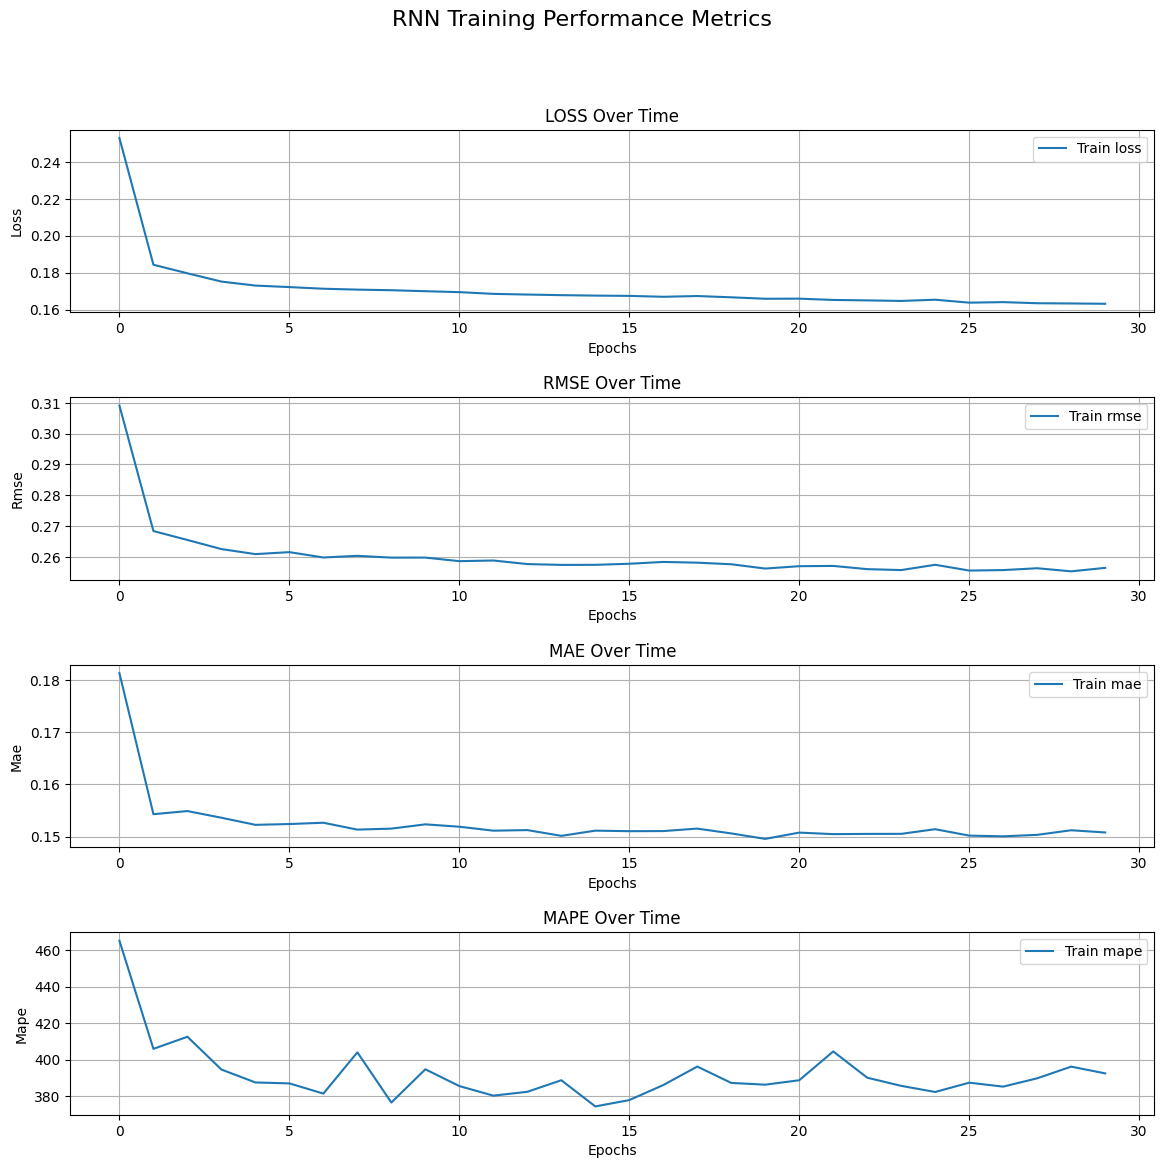

In [19]:
plot_metrics(rnn_training_data, title='RNN Training Performance Metrics')

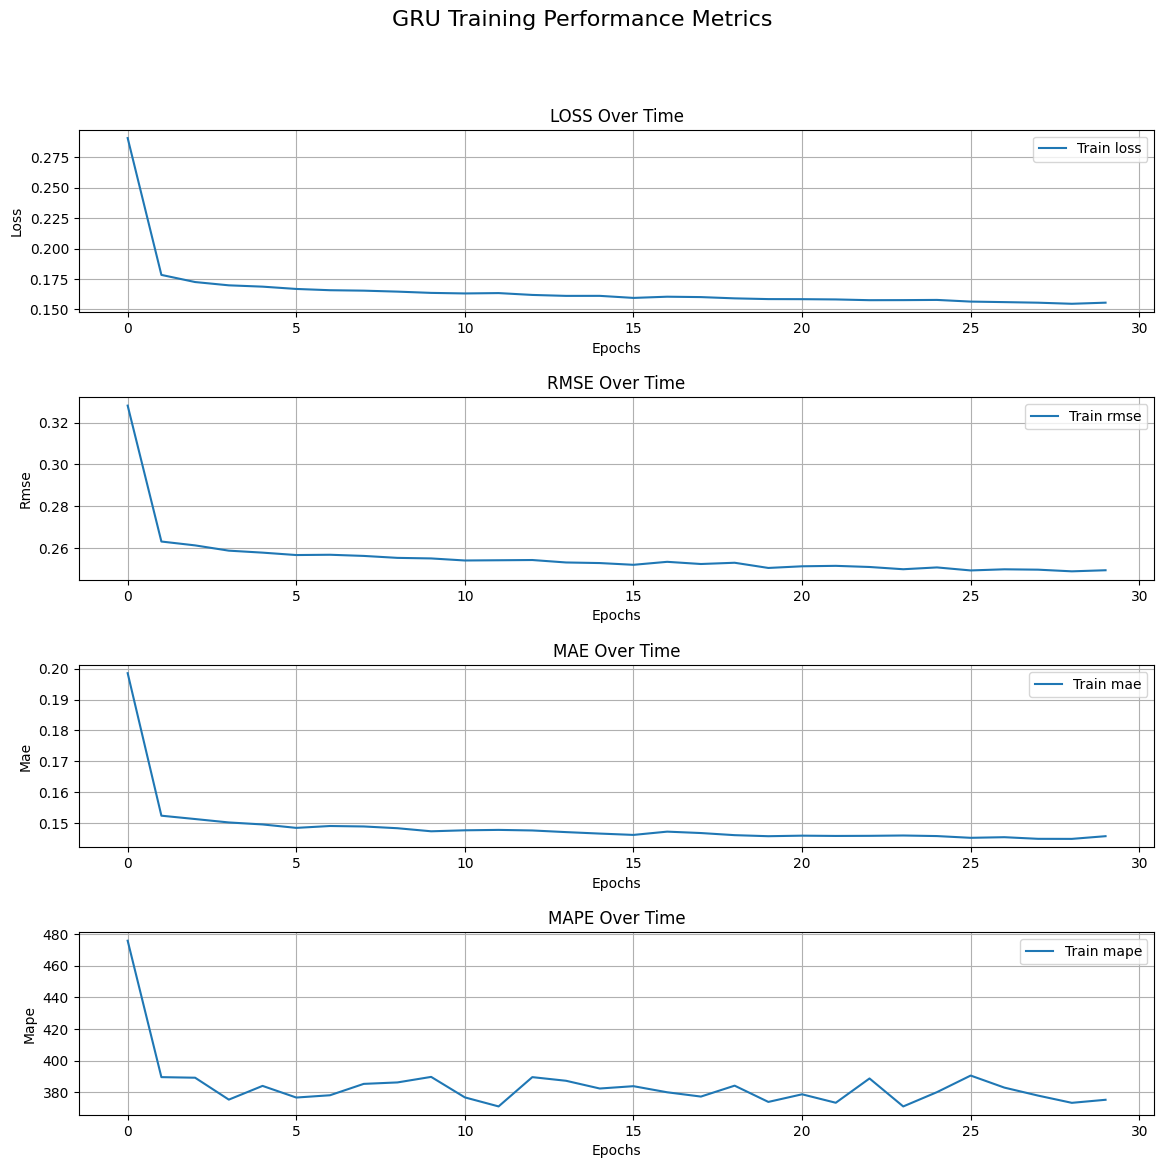

In [20]:
plot_metrics(gru_training_data, title='GRU Training Performance Metrics')

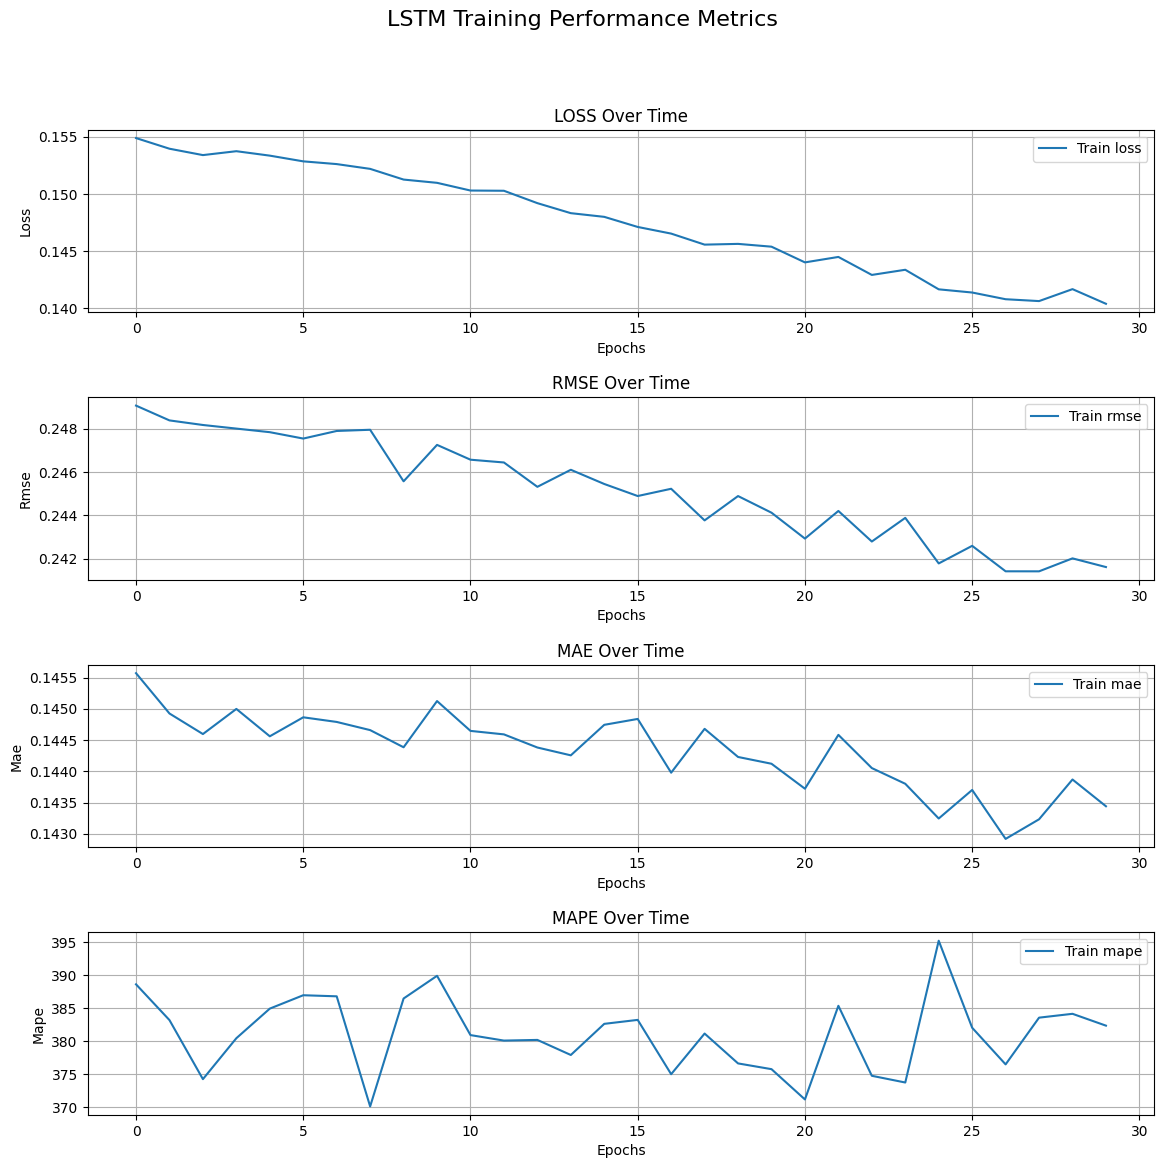

In [21]:
plot_metrics(lstm_training_data, title='LSTM Training Performance Metrics')